In [25]:
import os

import pandas as pd
import xgboost as xgb
from sklearn import preprocessing

from sklearn.metrics import roc_auc_score, recall_score, classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve, ConfusionMatrix
# from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

In [26]:
%config Completer.use_jedi = False  # for auto-completion

## Get train and validation datasets

In [27]:
TRAINING_FILE_PATH = "gs://card_fraud_asl_project/card_fraud_train_encoded_dataset.parquet"  # <-- Change this
VALIDATION_FILE_PATH = "gs://card_fraud_asl_project/card_fraud_val_encoded_dataset.parquet"  # <-- Change this

df_train = pd.read_parquet(TRAINING_FILE_PATH)
df_validation = pd.read_parquet(VALIDATION_FILE_PATH)

df_train.shape, df_validation.shape

((115386, 143), (28847, 143))

## Data preprocessing

In [28]:
df_train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'C1', 'C2', 'C11',
       ...
       'R_emaildomain_web.de', 'R_emaildomain_windstream.net',
       'R_emaildomain_yahoo.co.jp', 'R_emaildomain_yahoo.co.uk',
       'R_emaildomain_yahoo.com', 'R_emaildomain_yahoo.com.mx',
       'R_emaildomain_yahoo.de', 'R_emaildomain_yahoo.es',
       'R_emaildomain_yahoo.fr', 'R_emaildomain_ymail.com'],
      dtype='object', length=143)

Separation of numerical and categorical columns?

In [29]:
# numeric_feature_columns = ['TransactionID', 'isFraud', 
#                            'TransactionDT', 'TransactionAmt',
#                            'card1', 'card2', 'card3',  
#                            'C1', 'C2', 'C11', 'C12', 'C13', 'C14', 'D8', 'V45',
#                            'V87', 'V258']

# categorical_feature_columns = ['ProductCD', 'card6',
#                                'P_emaildomain', 'R_emaildomain',]

## X:y split

In [30]:
y_train = df_train.isFraud # target/label column
X_train = df_train.drop('isFraud', 
                        axis=1, # columns
                        inplace=False) # The original dataframe df remains the same

y_validation = df_validation.isFraud # target/label column
X_validation = df_validation.drop('isFraud', 
                                  axis=1, # columns
                                  inplace=False) # The original dataframe df remains the same

Sanity-check: whether columns match?

In [31]:
X_train.shape, X_validation.shape

((115386, 142), (28847, 142))

In [32]:
y_train.shape, y_validation.shape

((115386,), (28847,))

Replace missing values, with 0

In [33]:
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_validation = X_validation.fillna(0)
y_validation = y_validation.fillna(0)

Scaling

In [34]:
scaler = preprocessing.MinMaxScaler() # for numerical data

# fit as well as transform the training data
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

X_validation = scaler.transform(X_validation) # ONLY transform - NOT fit - on the validation (test) data

## Model selection and training

In [35]:
smote = SMOTE(random_state=0)  # minority over-sampling

under_sample = RandomUnderSampler(sampling_strategy=1.0) # majority under-sampling

xgb_class = xgb.XGBClassifier(random_state=42,
                              max_depth=12,
                              learning_rate=0.08,
                              objective="binary:logistic",
                              n_jobs=2,
                              scale_pos_weight=1)  # Assumption: ratio of majority:minority class must have been ~ 1 now.
                                                   # Reason: minority over-sampling and majority under-sampling

model = make_pipeline(smote, under_sample, xgb_class)
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:44:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=1.0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.08,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=2, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameter

Check whether distribution of labels is similar

In [36]:
y_train.value_counts(normalize=True) * 100

0    92.092628
1     7.907372
Name: isFraud, dtype: float64

In [37]:
y_validation.value_counts(normalize=True) * 100

0    92.394356
1     7.605644
Name: isFraud, dtype: float64

## Model perfromance metrics

In [38]:
y_pred = model.predict(X_validation)

In [39]:
predictions = model.predict_proba(X_validation)[:, 1]

# evaluate predictions
print ('ROC AUC Score: ', roc_auc_score(y_validation,
                                        predictions))

ROC AUC Score:  0.9547759566796215


In [40]:
print(confusion_matrix(y_validation,
                       y_pred))

[[26359   294]
 [  895  1299]]


/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


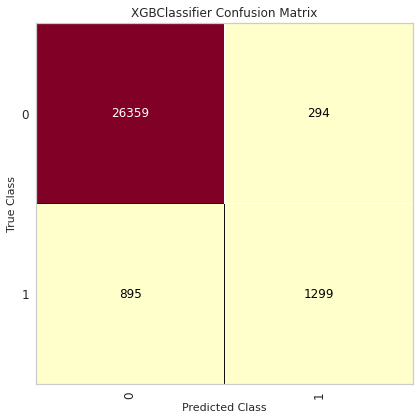

In [41]:
mapping = {0: "Genuine", 1: "Fraud"}

fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(model,
                         classes=["0", "1"],
                         label_encoder=mapping)

cm_viz.score(X_validation, y_validation)
cm_viz.poof()

In [42]:
print(classification_report(y_validation,
                            y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26653
           1       0.82      0.59      0.69      2194

    accuracy                           0.96     28847
   macro avg       0.89      0.79      0.83     28847
weighted avg       0.96      0.96      0.96     28847



/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


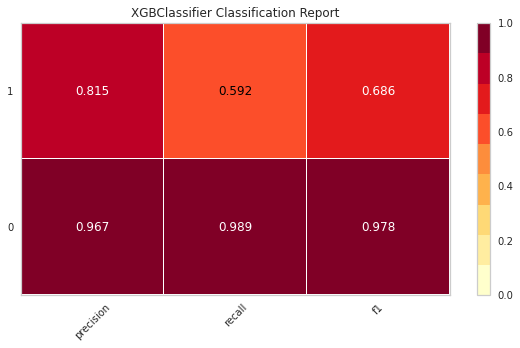

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
cm_viz = ClassificationReport(model,
                              classes=["0", "1"])

cm_viz.score(X_validation, y_validation)
cm_viz.poof()

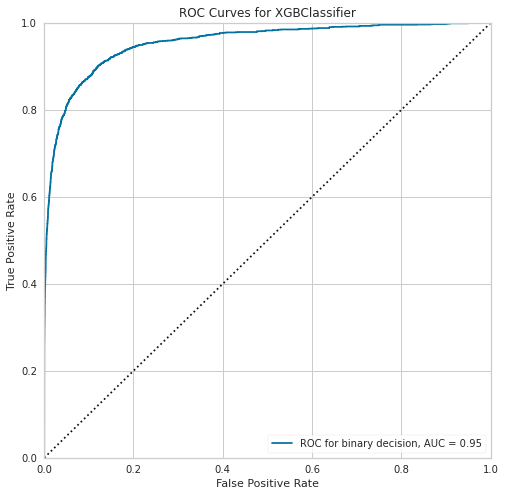

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_viz = ROCAUC(model,
                 classes=["0", "1"],
                 binary=True)

roc_viz.fit(X_train, y_train)  # Fit the training data to the visualizer
roc_viz.score(X_validation, y_validation)  # Evaluate the model on the test data
roc_viz.show()

## Decision Tree

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_tree(xgb_class,
              ax=ax,
              num_trees=0)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.369218 to fit
